# 프로젝트 - Movielens 영화 SBR

### 데이터 가져오기

In [1]:
import os
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


유저 ID : 6040개

아이템 ID : 3706개

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### Session Length

In [4]:
user_length = data.groupby('UserId').size()   # 한 유저ID가 몇 개의 영화에 평점 데이터를 남겼는지
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
user_length.median(), user_length.mean()   # 평균 한 유저ID 당 약 165개 평점을 남김, 중앙값은 96개

(96.0, 165.5975165562914)

In [6]:
user_length.min(), user_length.max()  # 최소 20개, 최대 2314개

(20, 2314)

In [7]:
user_length.quantile(0.999)           # 99.9%의 유저들은 1343개 이하의 rating을 가지고 있습니다.

1343.181000000005

In [8]:
user_length.quantile(0.9999) 

2033.790399999547

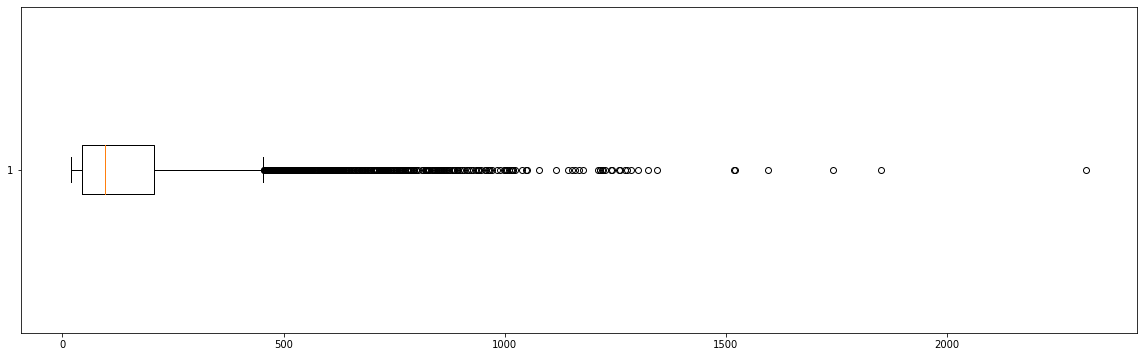

In [9]:
plt.figure(figsize=(20,6))
plt.boxplot(user_length, vert=0)
plt.show()

In [10]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

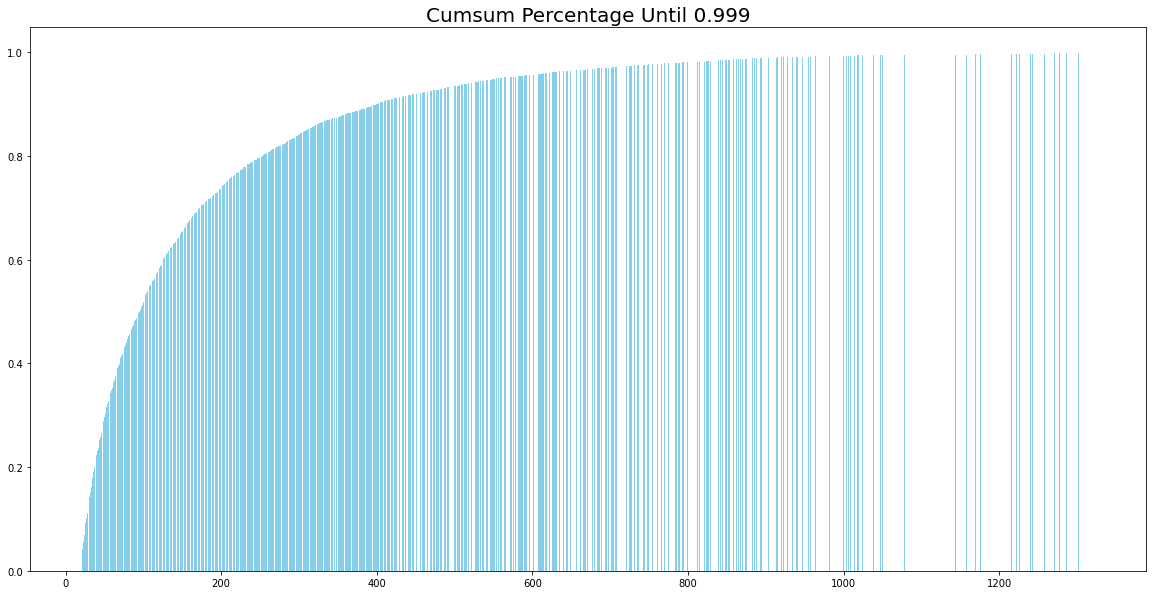

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='skyblue')
#plt.xticks(length_percent_cumsum_999.index)
#plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [12]:
# 어떤 영화에 세션 수가 많은지 보겠습니다
mv_count = data.groupby('ItemId')['UserId'].count()
mv_count.sort_values(ascending=False).head(10)

ItemId
2858    3428
260     2991
1196    2990
1210    2883
480     2672
2028    2653
589     2649
2571    2590
1270    2583
593     2578
Name: UserId, dtype: int64

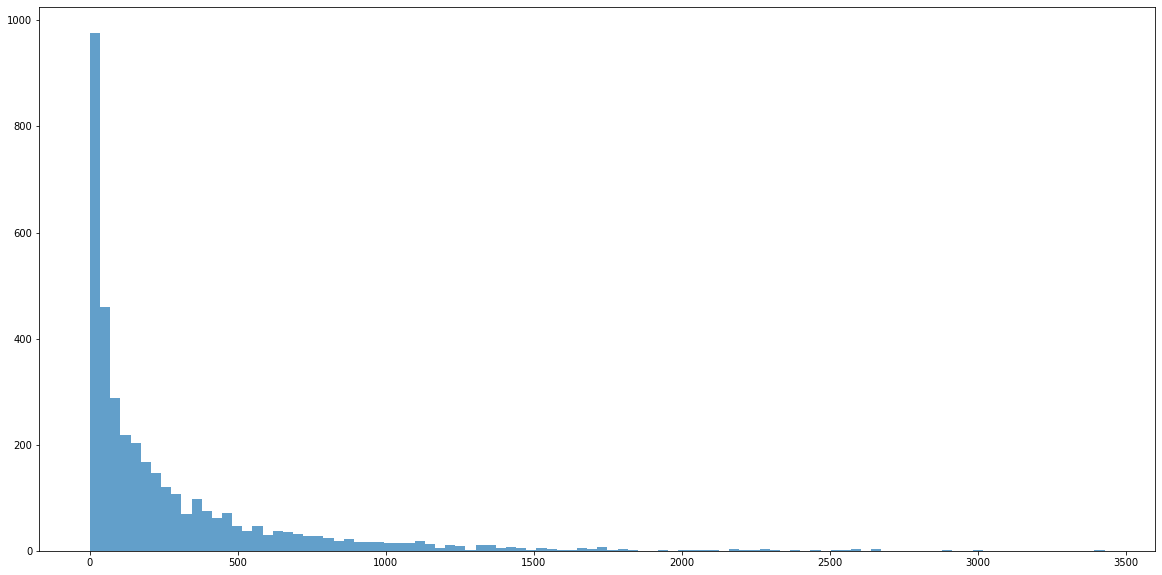

In [13]:
plt.figure(figsize=(20,10))
plt.hist(mv_count, bins=100, density=False, alpha=0.7, histtype='stepfilled')
plt.show()

In [14]:
long_rating = user_length[user_length==2314].index[0]
data[data['UserId']==long_rating]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


### Session Time

In [15]:
import datetime

In [16]:
# 우선 Time 컬럼이 보기가 힘드니 Date 로 바꿔서 보겠습니다

dt = datetime.datetime.strptime('1970-01-01', '%Y-%m-%d')
tmp = data['Time']
datatime = []
for i in tmp:
    date = dt + datetime.timedelta(seconds= i)
    tmp = date.strftime('%Y-%m-%d')
    datatime.append(tmp)

data['Date'] = datatime

In [17]:
data

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [18]:
oldest, latest = data['Date'].min(), data['Date'].max()
print(oldest) 
print(latest)

2000-04-25
2003-02-28


* 2000년 4월부터 2003년 2월까지의 데이터임을 알 수 있습니다. 

In [19]:
yr2000 = data[data['Date'].str.contains('2000')]
yr2001 = data[data['Date'].str.contains('2001')]
yr2002 = data[data['Date'].str.contains('2002')]
yr2003 = data[data['Date'].str.contains('2003')]

In [20]:
print(len(yr2000))
print(len(yr2001))
print(len(yr2002))
print(len(yr2003))

904757
68058
24046
3348


* 시간 흐름에 따른 영화 선호 함 보기
* 전체 기간에서 평점이 많이 남겨진 영화

In [21]:
#영화 평점 분포 확인

mv_rate = data.groupby('Rating')['ItemId'].count()
mv_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: ItemId, dtype: int64

In [22]:
# 2000년도에 가장 인기있는 영화는?
mv_count0 = yr2000.groupby('ItemId')['UserId'].count()
mv_count0.sort_values(ascending=False).head(10)

ItemId
2858    3291
1196    2846
260     2834
1210    2772
480     2559
589     2547
2028    2538
1270    2448
2571    2446
1580    2433
Name: UserId, dtype: int64

In [23]:
# 2001년도에 가장 인기있는 영화는?
mv_count1 = yr2001.groupby('ItemId')['UserId'].count()
mv_count1.sort_values(ascending=False).head(10)

ItemId
3897    266
3578    241
3751    213
3948    211
3317    199
3911    181
3408    179
3863    157
3793    151
3753    151
Name: UserId, dtype: int64

In [24]:
# 2002년도에 가장 인기있는 영화는?
mv_count2 = yr2002.groupby('ItemId')['UserId'].count()
mv_count2.sort_values(ascending=False).head(10)

ItemId
3897    68
3911    67
3949    57
3317    57
1393    56
1265    52
3948    49
3578    48
2628    48
2959    46
Name: UserId, dtype: int64

In [25]:
# 2003년도에 가장 인기있는 영화는?
mv_count3 = yr2003.groupby('ItemId')['UserId'].count()
mv_count3.sort_values(ascending=False).head(10)

ItemId
2011    14
2959    12
3948    12
2502    12
2012    11
3911    11
1095    11
2028    10
750     10
2300     9
Name: UserId, dtype: int64

### Rating score

In [26]:
# 가장 높은 평점을 가진 영화는 무엇인가
# 평점 순으로 줄세워보기
#영화 평점 분포 확인

mv_rate = data.groupby('Rating')['ItemId'].count()
mv_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: ItemId, dtype: int64

In [27]:
yr2000_rate = yr2000.groupby('Rating')['ItemId'].count()
yr2000_rate

Rating
1     51027
2     96069
3    234296
4    314446
5    208919
Name: ItemId, dtype: int64

In [28]:
yr2001_rate = yr2001.groupby('Rating')['ItemId'].count()
yr2001_rate

Rating
1     3539
2     7986
3    19150
4    24839
5    12544
Name: ItemId, dtype: int64

In [29]:
yr2002_rate = yr2002.groupby('Rating')['ItemId'].count()
yr2002_rate

Rating
1    1356
2    3113
3    6898
4    8500
5    4179
Name: ItemId, dtype: int64

In [30]:
yr2003_rate = yr2003.groupby('Rating')['ItemId'].count()
yr2003_rate

Rating
1     252
2     389
3     853
4    1186
5     668
Name: ItemId, dtype: int64

In [31]:
orginal_data_size = len(data)
orginal_data_size

1000209

In [32]:
# 전체 데이터셋에서 Rating 3점 이상만 남기겠습니다.

data = data[data['Rating']>=3]

filtered_data_size = len(data)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [33]:
data[data['Rating']==2]

,UserId,ItemId,Rating,Time,Date


In [34]:
data[data['Rating']==1]

,UserId,ItemId,Rating,Time,Date


제거된 것을 확인할 수 있다

### Data Cleansing

In [35]:
# 앞서 말했듯이 너무 긴 세션을 가지고 있는 UserID를 제거해주겠습니다.
# 남긴 평점이 적다고 해서 선호하는 영화가 아니라는 건 아니기도 하고 적은 평점을 가진 영화가 대부분이기도 하기때문에 
# 다른 cleansing 처리는 하지 않습니다.

def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len < longest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_recursive(data: pd.DataFrame, longest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [36]:
data = cleanse_recursive(data, 2314)

In [37]:
user_length = data.groupby('UserId').size()   # 한 유저ID가 몇 개의 영화에 평점 데이터를 남겼는지

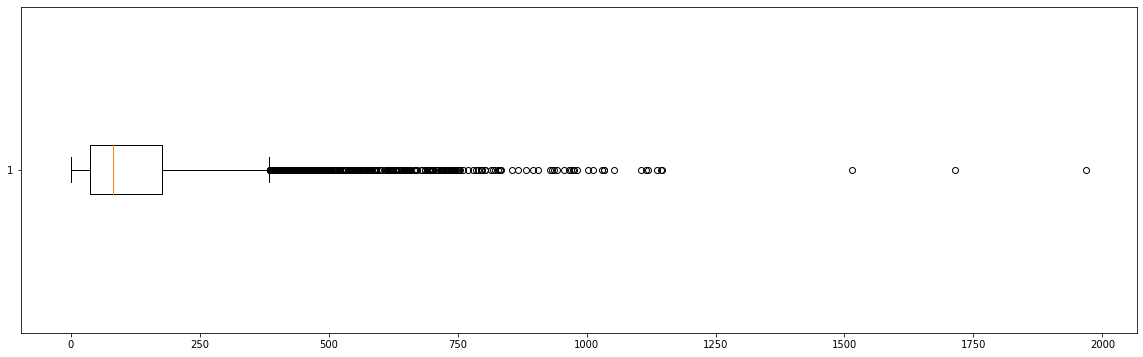

In [38]:
plt.figure(figsize=(20,6))
plt.boxplot(user_length, vert=0)
plt.show()

### Train/ Valid/ Test split

In [39]:
data['Date'].max()

'2003-02-28'

In [40]:
data.groupby('UserId')['Date'].max()

UserId
1       2001-01-06
2       2000-12-31
3       2000-12-31
4       2000-12-31
5       2000-12-31
           ...    
6036    2000-04-26
6037    2000-04-27
6038    2000-04-26
6039    2000-04-26
6040    2001-08-20
Name: Date, Length: 6039, dtype: object

In [41]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

def split_by_month(data: pd.DataFrame, n_months: int):
    final_time = pd.to_datetime(data['Date'].max())
    #print(final_time)
    session_last_time = data.groupby('UserId')['Date'].max()
    tmp = final_time - relativedelta(months = n_months)   # 맨 끝 날짜에서 n개월을 뺍니다
    tmpdate = tmp.strftime('%Y-%m-%d') # string 타입으로 변환
    #print(tmp)
    session_in_train = session_last_time[session_last_time < tmpdate].index
    session_in_test = session_last_time[session_last_time >= tmpdate].index
    
    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [42]:
train, test = split_by_month(data, n_months=14)
train, valid = split_by_month(train, n_months=8)

In [43]:
#train = pd.concat([yr2000,yr2001], ignore_index=True)
train

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
999798,6039,1148,4,956758002,2000-04-26
999764,6039,912,4,956758029,2000-04-26
999771,6039,922,5,956758029,2000-04-26
999815,6039,1204,5,956758029,2000-04-26


In [44]:
train['Date'].max()

'2001-04-25'

In [45]:
valid

,UserId,ItemId,Rating,Time,Date
2469,19,2527,3,978146700,2000-12-30
2298,19,593,5,978146713,2000-12-30
2432,19,527,3,978146727,2000-12-30
2457,19,1210,4,978146747,2000-12-30
2497,19,2115,3,978146747,2000-12-30
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [46]:
test

,UserId,ItemId,Rating,Time,Date
2522,20,2028,4,978143106,2000-12-30
2516,20,1617,5,978143181,2000-12-30
2515,20,47,5,978143306,2000-12-30
2514,20,3578,5,978143344,2000-12-30
2501,20,3863,3,978143355,2000-12-30
...,...,...,...,...,...
994100,6002,2013,4,1014524679,2002-02-24
993890,6002,2520,4,1014524680,2002-02-24
994045,6002,1387,5,1014524720,2002-02-24
993900,6002,1927,4,1014524758,2002-02-24


In [47]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Date"].min()}\n'
          f'\t Last Time : {data["Date"].max()}\n')

In [48]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 590449
	 Users: 5150
	 Items: 3556
	 First Time : 2000-04-25
	 Last Time : 2001-04-25

* valid Set Stats Info
	 Events: 63883
	 Users: 300
	 Items: 3076
	 First Time : 2000-04-25
	 Last Time : 2001-12-26

* test Set Stats Info
	 Events: 182046
	 Users: 589
	 Items: 3381
	 First Time : 2000-04-27
	 Last Time : 2003-02-28



In [49]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [50]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 미니 배치의 구성

Session-Parallel Mini Batch를 구현

여기서는 Session이 아닌 UserID 기반

In [51]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [52]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [53]:
train_dataset.click_offsets

array([     0,     53,    169, ..., 590312, 590330, 590449], dtype=int32)

In [54]:
train_dataset.session_idx

array([   0,    1,    2, ..., 5147, 5148, 5149])

### Session DataLoader

UserDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듦

mask는 후에 RNN Cell State를 초기화 하는데 사용

In [55]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [56]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [57]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [58]:
iter_ex = iter(train_data_loader)

In [59]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 모델 구성

In [60]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [62]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [63]:
class Args:
    def __init__(self, train, valid, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.valid = valid
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)

In [64]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [65]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.valid, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [66]:
train_model(model, args)

Evaluation:  21%|██▏       | 53/248 [01:08<04:12,  1.29s/it]


	 - Recall@20 epoch 1: 0.161483
	 - MRR@20    epoch 1: 0.039322



Evaluation:  21%|██▏       | 53/248 [01:04<03:55,  1.21s/it]


	 - Recall@20 epoch 2: 0.267468
	 - MRR@20    epoch 2: 0.070965



Evaluation:  21%|██▏       | 53/248 [01:02<03:50,  1.18s/it]


	 - Recall@20 epoch 3: 0.312721
	 - MRR@20    epoch 3: 0.087414



Evaluation:  21%|██▏       | 53/248 [01:01<03:45,  1.16s/it]


	 - Recall@20 epoch 4: 0.334242
	 - MRR@20    epoch 4: 0.097209



Evaluation:  21%|██▏       | 53/248 [01:00<03:43,  1.15s/it]


	 - Recall@20 epoch 5: 0.349646
	 - MRR@20    epoch 5: 0.103781



Evaluation:  21%|██▏       | 53/248 [00:59<03:39,  1.13s/it]


	 - Recall@20 epoch 6: 0.358196
	 - MRR@20    epoch 6: 0.109299



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 7: 0.363060
	 - MRR@20    epoch 7: 0.112247



Evaluation:  21%|██▏       | 53/248 [01:00<03:41,  1.14s/it]


	 - Recall@20 epoch 8: 0.367335
	 - MRR@20    epoch 8: 0.114108



Evaluation:  21%|██▏       | 53/248 [01:00<03:41,  1.13s/it]


	 - Recall@20 epoch 9: 0.370430
	 - MRR@20    epoch 9: 0.116728



Evaluation:  21%|██▏       | 53/248 [00:59<03:40,  1.13s/it]


	 - Recall@20 epoch 10: 0.369988
	 - MRR@20    epoch 10: 0.118452



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 11: 0.370873
	 - MRR@20    epoch 11: 0.119715



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 12: 0.372052
	 - MRR@20    epoch 12: 0.121336



Evaluation:  21%|██▏       | 53/248 [00:59<03:40,  1.13s/it]


	 - Recall@20 epoch 13: 0.374189
	 - MRR@20    epoch 13: 0.122595



Evaluation:  21%|██▏       | 53/248 [00:59<03:40,  1.13s/it]


	 - Recall@20 epoch 14: 0.374263
	 - MRR@20    epoch 14: 0.122775



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 15: 0.376621
	 - MRR@20    epoch 15: 0.123303



Evaluation:  21%|██▏       | 53/248 [00:59<03:40,  1.13s/it]


	 - Recall@20 epoch 16: 0.374042
	 - MRR@20    epoch 16: 0.123478



Evaluation:  21%|██▏       | 53/248 [00:59<03:40,  1.13s/it]


	 - Recall@20 epoch 17: 0.375811
	 - MRR@20    epoch 17: 0.123822



Evaluation:  21%|██▏       | 53/248 [00:59<03:37,  1.12s/it]


	 - Recall@20 epoch 18: 0.375074
	 - MRR@20    epoch 18: 0.123643



Evaluation:  21%|██▏       | 53/248 [00:59<03:39,  1.13s/it]


	 - Recall@20 epoch 19: 0.375221
	 - MRR@20    epoch 19: 0.123872



Evaluation:  21%|██▏       | 53/248 [00:58<03:34,  1.10s/it]


	 - Recall@20 epoch 20: 0.374189
	 - MRR@20    epoch 20: 0.123089



Evaluation:  21%|██▏       | 53/248 [00:58<03:34,  1.10s/it]


	 - Recall@20 epoch 21: 0.375369
	 - MRR@20    epoch 21: 0.123970



Evaluation:  21%|██▏       | 53/248 [00:58<03:34,  1.10s/it]


	 - Recall@20 epoch 22: 0.375737
	 - MRR@20    epoch 22: 0.123974



Evaluation:  21%|██▏       | 53/248 [00:58<03:34,  1.10s/it]


	 - Recall@20 epoch 23: 0.377948
	 - MRR@20    epoch 23: 0.124334



Evaluation:  21%|██▏       | 53/248 [00:58<03:33,  1.10s/it]


	 - Recall@20 epoch 24: 0.377874
	 - MRR@20    epoch 24: 0.124638



Evaluation:  21%|██▏       | 53/248 [00:59<03:37,  1.12s/it]


	 - Recall@20 epoch 25: 0.377432
	 - MRR@20    epoch 25: 0.124887



Evaluation:  21%|██▏       | 53/248 [00:58<03:36,  1.11s/it]


	 - Recall@20 epoch 26: 0.379201
	 - MRR@20    epoch 26: 0.124087



Evaluation:  21%|██▏       | 53/248 [00:59<03:37,  1.12s/it]


	 - Recall@20 epoch 27: 0.378096
	 - MRR@20    epoch 27: 0.124950



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 28: 0.377948
	 - MRR@20    epoch 28: 0.124531



Evaluation:  21%|██▏       | 53/248 [00:59<03:37,  1.12s/it]


	 - Recall@20 epoch 29: 0.376474
	 - MRR@20    epoch 29: 0.123748



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.10s/it]


	 - Recall@20 epoch 30: 0.378169
	 - MRR@20    epoch 30: 0.124163



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 31: 0.377653
	 - MRR@20    epoch 31: 0.124518



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.11s/it]


	 - Recall@20 epoch 32: 0.376032
	 - MRR@20    epoch 32: 0.124122



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 33: 0.377653
	 - MRR@20    epoch 33: 0.124311



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.10s/it]


	 - Recall@20 epoch 34: 0.378169
	 - MRR@20    epoch 34: 0.124333



Evaluation:  21%|██▏       | 53/248 [00:58<03:34,  1.10s/it]


	 - Recall@20 epoch 35: 0.376179
	 - MRR@20    epoch 35: 0.123892



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.10s/it]


	 - Recall@20 epoch 36: 0.377580
	 - MRR@20    epoch 36: 0.123813



Evaluation:  21%|██▏       | 53/248 [00:58<03:36,  1.11s/it]


	 - Recall@20 epoch 37: 0.376843
	 - MRR@20    epoch 37: 0.123930



Evaluation:  21%|██▏       | 53/248 [00:59<03:37,  1.12s/it]


	 - Recall@20 epoch 38: 0.377285
	 - MRR@20    epoch 38: 0.124151



Evaluation:  21%|██▏       | 53/248 [00:59<03:38,  1.12s/it]


	 - Recall@20 epoch 39: 0.376990
	 - MRR@20    epoch 39: 0.123530



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.10s/it]


	 - Recall@20 epoch 40: 0.375958
	 - MRR@20    epoch 40: 0.124029



Evaluation:  21%|██▏       | 53/248 [00:58<03:36,  1.11s/it]


	 - Recall@20 epoch 41: 0.377653
	 - MRR@20    epoch 41: 0.123824



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.11s/it]


	 - Recall@20 epoch 42: 0.376990
	 - MRR@20    epoch 42: 0.123623



Evaluation:  21%|██▏       | 53/248 [00:58<03:36,  1.11s/it]


	 - Recall@20 epoch 43: 0.377211
	 - MRR@20    epoch 43: 0.123414



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.11s/it]


	 - Recall@20 epoch 44: 0.376695
	 - MRR@20    epoch 44: 0.123192



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.10s/it]


	 - Recall@20 epoch 45: 0.375442
	 - MRR@20    epoch 45: 0.123535



Evaluation:  21%|██▏       | 53/248 [00:58<03:34,  1.10s/it]


	 - Recall@20 epoch 46: 0.376106
	 - MRR@20    epoch 46: 0.123231



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.11s/it]


	 - Recall@20 epoch 47: 0.375590
	 - MRR@20    epoch 47: 0.123388



Evaluation:  21%|██▏       | 53/248 [00:59<03:39,  1.12s/it]


	 - Recall@20 epoch 48: 0.374779
	 - MRR@20    epoch 48: 0.122945



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.11s/it]


	 - Recall@20 epoch 49: 0.373305
	 - MRR@20    epoch 49: 0.122827



Evaluation:  21%|██▏       | 53/248 [00:58<03:35,  1.10s/it]

	 - Recall@20 epoch 50: 0.374853
	 - MRR@20    epoch 50: 0.123109



## 모델 테스트

In [67]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  67%|██████▋   | 473/708 [09:21<04:38,  1.19s/it]

	 - Recall@20: 0.282381
	 - MRR@20: 0.085909



### 하이퍼파라미터 변경 모델

In [68]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.4, lr=0.01, epochs=30, k=20)

In [69]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [70]:
train_model(model, args)

Evaluation:  59%|█████▊    | 291/496 [03:01<02:07,  1.61it/s]


	 - Recall@20 epoch 1: 0.270726
	 - MRR@20    epoch 1: 0.071381



Evaluation:  59%|█████▊    | 291/496 [03:00<02:07,  1.61it/s]


	 - Recall@20 epoch 2: 0.280257
	 - MRR@20    epoch 2: 0.075170



Evaluation:  59%|█████▊    | 291/496 [03:00<02:06,  1.62it/s]


	 - Recall@20 epoch 3: 0.286539
	 - MRR@20    epoch 3: 0.077555



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 4: 0.289116
	 - MRR@20    epoch 4: 0.078035



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 5: 0.287693
	 - MRR@20    epoch 5: 0.078698



Evaluation:  59%|█████▊    | 291/496 [03:00<02:07,  1.61it/s]


	 - Recall@20 epoch 6: 0.289492
	 - MRR@20    epoch 6: 0.079187



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 7: 0.289062
	 - MRR@20    epoch 7: 0.079047



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 8: 0.290593
	 - MRR@20    epoch 8: 0.077739



Evaluation:  59%|█████▊    | 291/496 [03:00<02:07,  1.61it/s]


	 - Recall@20 epoch 9: 0.289197
	 - MRR@20    epoch 9: 0.077839



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 10: 0.291559
	 - MRR@20    epoch 10: 0.078899



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 11: 0.290029
	 - MRR@20    epoch 11: 0.079104



Evaluation:  59%|█████▊    | 291/496 [02:58<02:05,  1.63it/s]


	 - Recall@20 epoch 12: 0.291345
	 - MRR@20    epoch 12: 0.078212



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 13: 0.290297
	 - MRR@20    epoch 13: 0.078213



Evaluation:  59%|█████▊    | 291/496 [03:00<02:07,  1.61it/s]


	 - Recall@20 epoch 14: 0.287908
	 - MRR@20    epoch 14: 0.077628



Evaluation:  59%|█████▊    | 291/496 [03:00<02:07,  1.61it/s]


	 - Recall@20 epoch 15: 0.290163
	 - MRR@20    epoch 15: 0.078821



Evaluation:  59%|█████▊    | 291/496 [03:00<02:07,  1.61it/s]


	 - Recall@20 epoch 16: 0.290969
	 - MRR@20    epoch 16: 0.078713



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 17: 0.291962
	 - MRR@20    epoch 17: 0.078746



Evaluation:  59%|█████▊    | 291/496 [03:00<02:07,  1.61it/s]


	 - Recall@20 epoch 18: 0.289948
	 - MRR@20    epoch 18: 0.078707



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 19: 0.291855
	 - MRR@20    epoch 19: 0.079213



Evaluation:  59%|█████▊    | 291/496 [02:58<02:06,  1.63it/s]


	 - Recall@20 epoch 20: 0.292230
	 - MRR@20    epoch 20: 0.078734



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 21: 0.287828
	 - MRR@20    epoch 21: 0.078370



Evaluation:  59%|█████▊    | 291/496 [02:57<02:05,  1.64it/s]


	 - Recall@20 epoch 22: 0.291828
	 - MRR@20    epoch 22: 0.079552



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 23: 0.289304
	 - MRR@20    epoch 23: 0.078632



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 24: 0.286458
	 - MRR@20    epoch 24: 0.078022



Evaluation:  59%|█████▊    | 291/496 [03:01<02:07,  1.61it/s]


	 - Recall@20 epoch 25: 0.289036
	 - MRR@20    epoch 25: 0.078360



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 26: 0.289599
	 - MRR@20    epoch 26: 0.078053



Evaluation:  59%|█████▊    | 291/496 [02:58<02:06,  1.63it/s]


	 - Recall@20 epoch 27: 0.291452
	 - MRR@20    epoch 27: 0.078787



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]


	 - Recall@20 epoch 28: 0.289787
	 - MRR@20    epoch 28: 0.078540



Evaluation:  59%|█████▊    | 291/496 [02:58<02:05,  1.63it/s]


	 - Recall@20 epoch 29: 0.291237
	 - MRR@20    epoch 29: 0.078765



Evaluation:  59%|█████▊    | 291/496 [02:59<02:06,  1.62it/s]

	 - Recall@20 epoch 30: 0.288096
	 - MRR@20    epoch 30: 0.079198



In [71]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1181/1417 [12:24<02:28,  1.59it/s]

	 - Recall@20: 0.237054
	 - MRR@20: 0.063168



### 모델 구조 (loss 종류) 변경

In [72]:
from tensorflow.keras.losses import mse

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=mse, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [73]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [74]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [75]:
train_model(model, args)

Evaluation:  59%|█████▊    | 291/496 [03:22<02:22,  1.44it/s]


	 - Recall@20 epoch 1: 0.068218
	 - MRR@20    epoch 1: 0.013653



Evaluation:  59%|█████▊    | 291/496 [03:20<02:20,  1.45it/s]


	 - Recall@20 epoch 2: 0.069561
	 - MRR@20    epoch 2: 0.014070



Evaluation:  59%|█████▊    | 291/496 [03:19<02:20,  1.46it/s]


	 - Recall@20 epoch 3: 0.070178
	 - MRR@20    epoch 3: 0.014118



Evaluation:  59%|█████▊    | 291/496 [03:20<02:21,  1.45it/s]


	 - Recall@20 epoch 4: 0.070339
	 - MRR@20    epoch 4: 0.014135



Evaluation:  59%|█████▊    | 291/496 [03:22<02:22,  1.44it/s]


	 - Recall@20 epoch 5: 0.070581
	 - MRR@20    epoch 5: 0.014145



Evaluation:  59%|█████▊    | 291/496 [03:19<02:20,  1.46it/s]


	 - Recall@20 epoch 6: 0.070474
	 - MRR@20    epoch 6: 0.014131



Evaluation:  59%|█████▊    | 291/496 [03:20<02:21,  1.45it/s]


	 - Recall@20 epoch 7: 0.070420
	 - MRR@20    epoch 7: 0.014126



Evaluation:  59%|█████▊    | 291/496 [03:20<02:21,  1.45it/s]


	 - Recall@20 epoch 8: 0.070339
	 - MRR@20    epoch 8: 0.014123



Evaluation:  59%|█████▊    | 291/496 [03:20<02:21,  1.45it/s]


	 - Recall@20 epoch 9: 0.070420
	 - MRR@20    epoch 9: 0.014121



Evaluation:  59%|█████▊    | 291/496 [03:22<02:22,  1.43it/s]

	 - Recall@20 epoch 10: 0.070420
	 - MRR@20    epoch 10: 0.014115



In [76]:

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1181/1417 [13:42<02:44,  1.44it/s]

	 - Recall@20: 0.047470
	 - MRR@20: 0.009189



# [E-16] 회고

이번 익스도😅😅 혼자 해결하는 과정에서 문제가 생겨서 다른 분의 깃허브를 참고 했습니다.

https://github.com/hyunnie94/AIFFEL/blob/master/E17_SessionBasedRecommendation/%5BE17%5D%20Movielens%20Session%20Based%20Recommendation.ipynb


변명아닌 변명, 핑계아닌 핑계로 데이터톤을 끝내고 나니까 머리속에 남아있는 내용이 거의 남아있지 않아서,
다른 분의 깃허브를 보니 어느정도 기억이 나면서, 이해가 되더라구요.

전처리를 진행하는 과정에서 사용하지 않는 데이터는 삭제하고, 미니 배치를 할 때 도움을 받으니
이번 익스도 무사히 해결한 것 같습니다.

무사히 잘 해결했으니 과제 제출에 급급해서 이해가 어려웠던 부분은 다시보려고 합니당😂
밀렸던 오답도 얼른얼른 끝내야 겠네요🔥🔥🔥